In [32]:
from files.utils.constants import *
from files.utils.utility_functions import *
from files.utils.dataset_creator import *
from files.neural_networks.base_class import *

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

In [33]:
def to_img(arr):
    return arr.reshape(800, 800, 3)

def to_net_inp(arr):
    return arr.reshape(1, 3, 800, 800)

def to_net_train(arr):
    return arr.reshape(3, 800, 800)

In [34]:
from PIL import Image

base_path = "../../datasets/potato/000/"

# img = plt.imread(joinpath(base_path, "me_buona.jpg"))
img = Image.open(joinpath(base_path, "000_rgb.png"))
transform = T.Resize((800, 800))
img = transform(img)# .detach().numpy()

img = np.asarray(img)

(torch.Size([800, 800, 3]), (800, 800, 3))

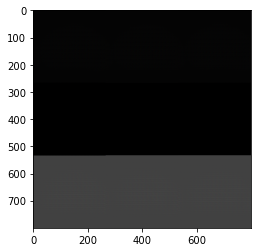

In [35]:
class Net(nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
        self.loss = nn.MSELoss()
        self.device = torch.device(device) if device.lower() == "cuda" and torch.cuda.is_available() else torch.device("cpu")
        self.to(self.device)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 6, 3, padding=2)
        self.conv2 = nn.Conv2d(6, 12, 3, padding=2)
        self.conv3 = nn.Conv2d(12, 12*3, 4, padding=1)
        self.conv4 = nn.Conv2d(12*3, 12*5, 3, padding=1)

        self.c_transpose1 = nn.ConvTranspose2d(12*5, 12*3, 2, stride=2)
        self.c_transpose2 = nn.ConvTranspose2d(12*3, 12, 2, stride=2)
        self.c_transpose3 = nn.ConvTranspose2d(12, 6, 2, stride=2)
        self.c_transpose4 = nn.ConvTranspose2d(6, 3, 2, stride=2)

    def forward(self, x):
        x = self.tensor_from_np([x])

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = F.relu(self.c_transpose1(x))
        x = F.relu(self.c_transpose2(x))
        x = F.relu(self.c_transpose3(x))
        x = F.relu(self.c_transpose4(x))
        return x

    def get_activations(self, x):
        activations = []
        x = self.tensor_from_np([x])
        # activations.append(x)
        x = self.pool(F.relu(self.conv1(x)))
        activations.append(x)
        x = self.pool(F.relu(self.conv2(x)))
        activations.append(x)
        x = self.pool(F.relu(self.conv3(x)))
        activations.append(x)
        x = self.pool(F.relu(self.conv4(x)))
        activations.append(x)

        x = F.relu(self.c_transpose1(x))
        activations.append(x)
        x = F.relu(self.c_transpose2(x))
        activations.append(x)
        x = F.relu(self.c_transpose3(x))
        activations.append(x)
        x = F.relu(self.c_transpose4(x))
        # activations.append(x)

        return activations
    
    def tensor_from_np(self, arrs):
        res = [torch.FloatTensor(arr).to(self.device) if arr is not None else None if not isinstance(
            arr, torch.Tensor) else arr for arr in arrs]
        res = [arr.unsqueeze(1) if arr is not None and len(
            arr.shape) == 1 else arr for arr in res]
        if len(res) == 1:
            return res[0]
        else:
            return res
    
    def fit(self, data, epochs=5, lr=1e-2, bs=16, print_training=False):
        data = self.tensor_from_np([data])

        torch_dataset = Data.TensorDataset(data, data)  # [:,1].unsqueeze(1))
        loader = Data.DataLoader(
            dataset=torch_dataset,
            batch_size=bs,
            # num_workers=16,
            shuffle=True)

        self.optimizer = torch.optim.AdamW(self.parameters(), lr=lr)

        return train(epochs=epochs,
                     model=self,
                     dataset=loader,
                     print_training=print_training
                     )


net = Net(device="gpu")
inp = to_net_inp(img)
res = net(inp)
res = to_img(res)
plt.imshow(res.detach().numpy())
res.shape, img.shape

In [36]:
net.fit([to_net_train(img) for _ in range(64)], print_training=True, epochs=10, lr=5e-3);

Epoch 1/10. Batch 4/4: [==============================] (100%) ETA: 0:00:08.313987 Mean Loss: 599.3317
Epoch 2/10. Batch 4/4: [==============================] (100%) ETA: 0:00:08.296239 Mean Loss: 556.4869
Epoch 3/10. Batch 4/4: [==============================] (100%) ETA: 0:00:08.126865 Mean Loss: 550.3322
Epoch 4/10. Batch 4/4: [==============================] (100%) ETA: 0:00:08.059402 Mean Loss: 510.0983
Epoch 5/10. Batch 4/4: [==============================] (100%) ETA: 0:00:08.083941 Mean Loss: 471.3473
Epoch 6/10. Batch 4/4: [==============================] (100%) ETA: 0:00:07.852118 Mean Loss: 442.9839
Epoch 7/10. Batch 4/4: [==============================] (100%) ETA: 0:00:07.895083 Mean Loss: 419.1215
Epoch 8/10. Batch 4/4: [==============================] (100%) ETA: 0:00:07.691939 Mean Loss: 403.9447
Epoch 9/10. Batch 4/4: [==============================] (100%) ETA: 0:00:08.058301 Mean Loss: 393.3020
Epoch 10/10. Batch 4/4: [==============================] (100%) ETA: 0:00

/tmp/ipykernel_87941/3340096803.py:30: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
/opt/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/opt/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/opt/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/patches.py:769: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/opt/anaconda3/envs/torch/lib/python3.8/site-packages/matplotlib/transforms.py:2013: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


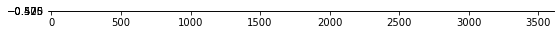

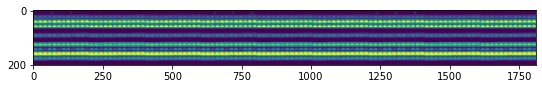

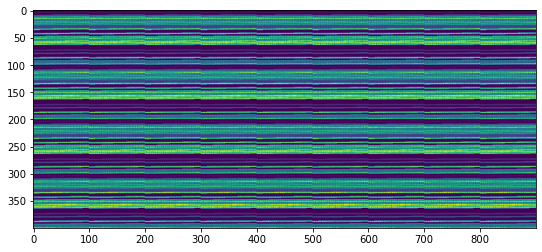

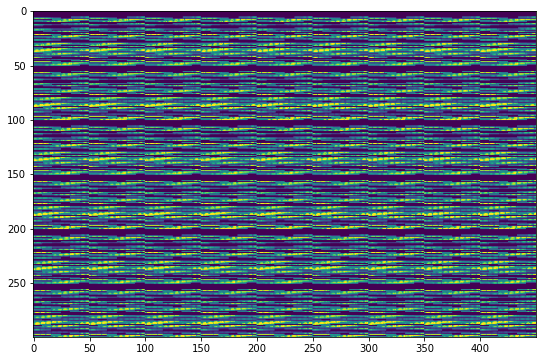

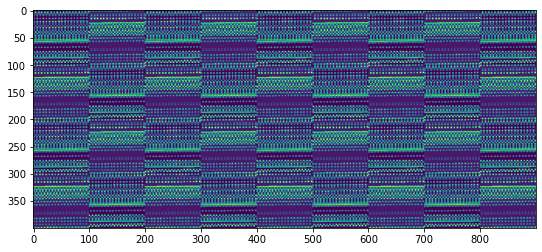

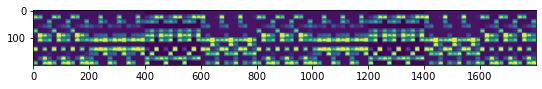

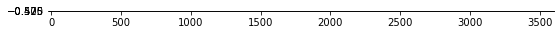

In [37]:
activations = net.get_activations(inp)
images_per_row = 9

for layer_activation in activations: # Displays the feature maps
    layer_activation = layer_activation.detach().numpy()
    shape = layer_activation.shape
    layer_activation = layer_activation.reshape((1, shape[2], shape[3], shape[1]))
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    # plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(torch.Size([800, 800, 3]), (800, 800, 3))

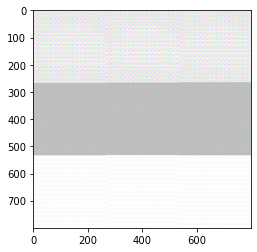

In [38]:
res = net(inp)
res = res.reshape((res.shape[-2], res.shape[-1], res.shape[1]))
plt.imshow(res.detach().numpy())
res.shape, img.shape

In [39]:
activs = net.get_activations(inp)
plt.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'